In [2]:
from scipy.io import arff
from scipy import signal

import numpy as np
import sklearn as sk
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib
import warnings

warnings.filterwarnings("ignore", category=matplotlib.MatplotlibDeprecationWarning)

%matplotlib inline

In [3]:
data = arff.loadarff('tecator.arff')

In [4]:
df_data = pd.DataFrame(data[0])

In [5]:
df_data.head()

,absorbance_1,absorbance_2,absorbance_3,absorbance_4,absorbance_5,absorbance_6,absorbance_7,absorbance_8,absorbance_9,absorbance_10,...,principal_component_16,principal_component_17,principal_component_18,principal_component_19,principal_component_20,principal_component_21,principal_component_22,moisture,fat,protein
0,2.61776,2.61814,2.61859,2.61912,2.61981,2.62071,2.62186,2.62334,2.62511,2.62722,...,0.233876,0.899661,-0.042006,0.708717,-0.254173,-0.391579,-0.419313,60.5,22.5,16.7
1,2.83454,2.83871,2.84283,2.84705,2.85138,2.85587,2.86060,2.86566,2.87093,2.87661,...,-0.195980,-0.046359,-0.634996,-0.354403,0.014650,0.269542,0.096692,46.0,40.1,13.5
2,2.58284,2.58458,2.58629,2.58808,2.58996,2.59192,2.59401,2.59627,2.59873,2.60131,...,0.795466,0.762246,-1.268580,0.690588,-0.785592,-0.671237,-0.710290,71.0,8.4,20.5
3,2.82286,2.82460,2.82630,2.82814,2.83001,2.83192,2.83392,2.83606,2.83842,2.84097,...,0.616500,-0.388684,-2.068390,1.276160,-0.259437,-0.140206,-0.165963,72.8,5.9,20.7
4,2.78813,2.78989,2.79167,2.79350,2.79538,2.79746,2.79984,2.80254,2.80553,2.80890,...,-1.095540,-1.348450,0.453559,0.402624,0.031307,0.021824,0.145777,58.3,25.5,15.5


array des:
- absorbances
- composantes principales
- % gras

In [6]:
n_samples = 215
ab_array = df_data.iloc[:n_samples,:100].to_numpy()

pc_array = df_data.iloc[:n_samples,100:122].to_numpy()

fat_array = df_data.iloc[:n_samples,-2].to_numpy()

[Text(1, 0.0, 'low fat'), Text(1, 1.0, 'high fat')]

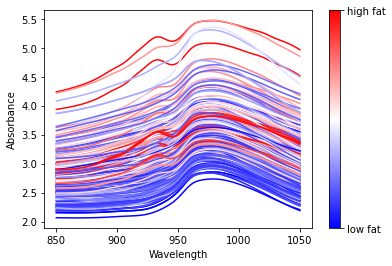

In [7]:
#colormap (blue: low fat, red: high fat)
cm_fat = plt.cm.bwr((fat_array-np.min(fat_array))/(np.max(fat_array)-np.min(fat_array)))

X = np.linspace(850,1050,100)

fig, ax = plt.subplots()
ax.set_prop_cycle('color', list(cm_fat))
ax.set_xlabel('Wavelength')
ax.set_ylabel('Absorbance')

for i in range(n_samples):
    ax.plot(X, ab_array[i])

sm = plt.cm.ScalarMappable(cmap='bwr')
sm.set_array([])
  
cbar = fig.colorbar(sm, ticks=np.linspace(0, 1, 2))
cbar.ax.set_yticklabels(['low fat', 'high fat'])

# Répartitions des données % gras

(array([68., 42., 29., 19., 14.]),
 array([ 0.9 , 10.54, 20.18, 29.82, 39.46, 49.1 ]),
 <a list of 5 Patch objects>)

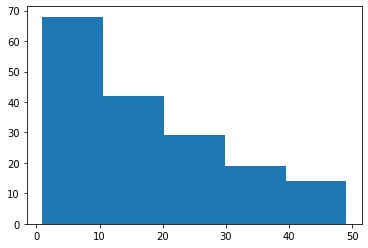

In [9]:
plt.hist(fat_array[:172], bins=5)

# Exploration visuelle

## Spectre d'absorbance

On recalibre "à la main" les courbes en soustrayant la valeur moyenne des spectres

In [8]:
ab_tare_array = ab_array - (ab_array[:,:].mean(axis=1)).reshape(n_samples,1)
# ab_tare_array = ab_array - (ab_array[:,0]).reshape(n_samples,1)

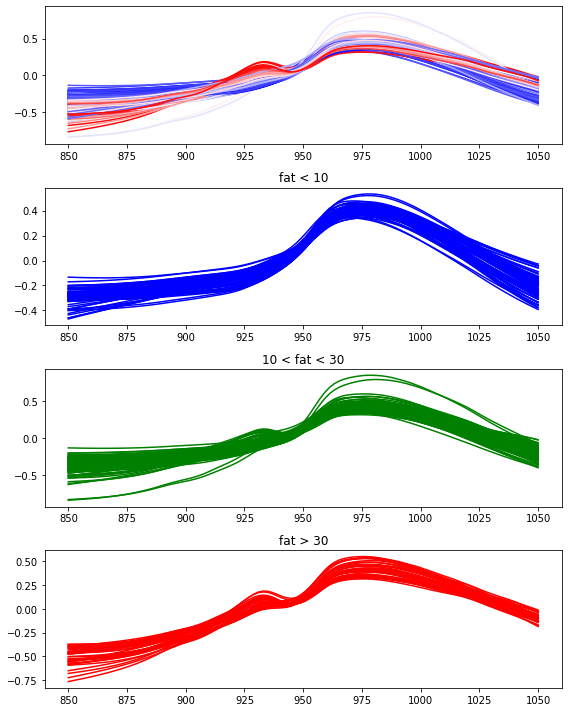

In [11]:
fig, ax = plt.subplots(4,1, figsize=(8,10))
ax[0].set_prop_cycle('color', list(cm_fat))

X = np.linspace(850,1050,100)

for i in range(n_samples):
    ax[0].plot(X, ab_tare_array[i])

for i in np.where(fat_array<10)[0]:
    ax[1].plot(X, ab_tare_array[i], c='b')
    ax[1].set_title('fat < 10')

for i in np.where(fat_array[np.where(fat_array<30)]>10)[0]:
    ax[2].plot(X, ab_tare_array[i], c='green')
    ax[2].set_title('10 < fat < 30')
plt.tight_layout()
    
for i in np.where(fat_array>=30)[0]:
    ax[3].plot(X, ab_tare_array[i], c='r')
    ax[3].set_title('fat > 30')
plt.tight_layout()

outliers indices =  (array([ 33,  34, 139]),)


Text(0, 0.5, 'Fat')

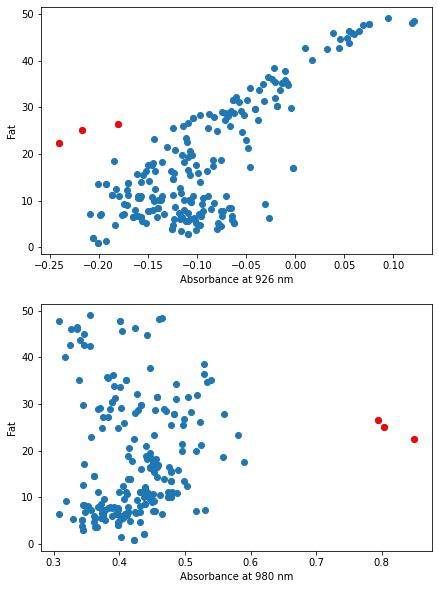

In [15]:
fig, ax = plt.subplots(2,1, figsize = (7,10))

ax[0].scatter(ab_tare_array[:,38], fat_array)
ax[1].scatter(ab_tare_array[:,65], fat_array)

out_inds = ab_tare_array[:,65]>0.7
no_out_inds = ab_tare_array[:,65]<=0.7
print("outliers indices = ", np.where(out_inds))

ax[0].scatter(ab_tare_array[:,38][out_inds], fat_array[out_inds], c='red')
ax[1].scatter(ab_tare_array[:,65][out_inds], fat_array[out_inds], c='red')

ax[0].set_xlabel(f'Absorbance at {850+38*2} nm')
ax[1].set_xlabel(f'Absorbance at {850+65*2} nm')
ax[0].set_ylabel('Fat')
ax[1].set_ylabel('Fat')

Au niveau du premier "pic" d'absorbance, on entrevoit une dépendance linéaire du % de gras avec la hauteur de ce pic. 
Mais cela ne s'observe que pour les échantillons les plus gras (gras>30%).

Le second "pic" semble peu corrélé au % de gras

On identifie trois potentiels outliers.

## Dérivées des absorbances

Avec les dérivées :
- on a l'information sur comment l'absorbance varie (oui oui !)
- cette information n'est pas sensible à l'étalonnage

### Premier ordre

In [9]:
dab_array = np.gradient(ab_array, axis=1)

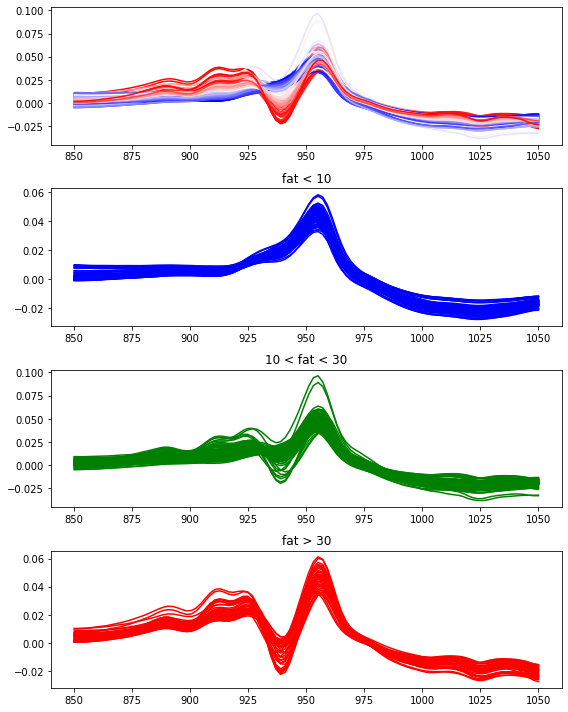

In [14]:
fig, ax = plt.subplots(4,1, figsize=(8,10))
ax[0].set_prop_cycle('color', list(cm_fat))

X = np.linspace(850,1050,100)

for i in range(n_samples):
    ax[0].plot(X, dab_array[i])

for i in np.where(fat_array<10)[0]:
    ax[1].plot(X, dab_array[i], c='b')
    ax[1].set_title('fat < 10')

for i in np.where(fat_array[np.where(fat_array<30)]>10)[0]:
    ax[2].plot(X, dab_array[i], c='green')
    ax[2].set_title('10 < fat < 30')
plt.tight_layout()
    
for i in np.where(fat_array>=30)[0]:
    ax[3].plot(X, dab_array[i], c='r')
    ax[3].set_title('fat > 30')
plt.tight_layout()

Text(0, 0.5, 'Fat')

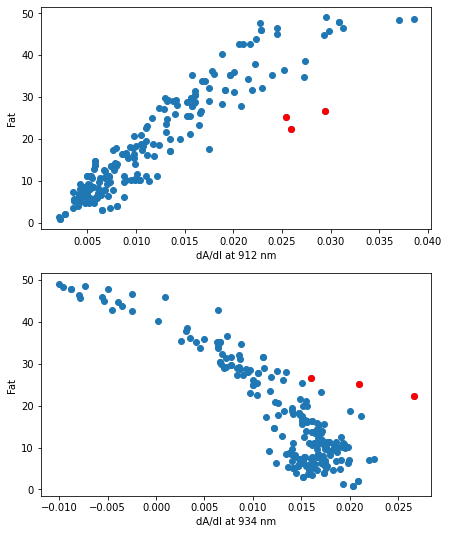

In [15]:
fig, ax = plt.subplots(2,1, figsize = (7,9))
ax[0].scatter(dab_array[:,31], fat_array)
ax[1].scatter(dab_array[:,42], fat_array)

ax[0].scatter(dab_array[:,31][out_inds],fat_array[out_inds], c='r')
ax[1].scatter(dab_array[:,42][out_inds],fat_array[out_inds], c='r')

ax[0].set_xlabel(f'dA/dl at {850+31*2} nm')
ax[1].set_xlabel(f'dA/dl at {850+42*2} nm')
ax[0].set_ylabel('Fat')
ax[1].set_ylabel('Fat')

### Dérivée du second ordre

In [10]:
ddab_array = np.gradient(dab_array, axis=1)

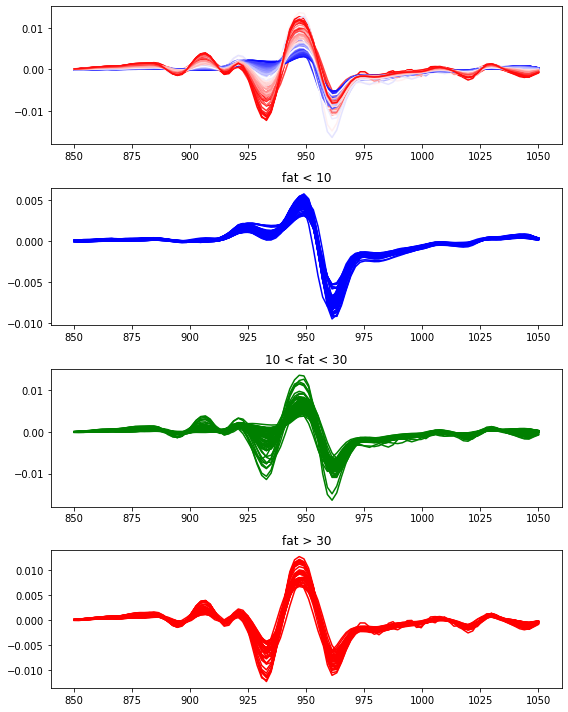

In [17]:
fig, ax = plt.subplots(4,1, figsize=(8,10))
ax[0].set_prop_cycle('color', list(cm_fat))

X = np.linspace(850,1050,100)

for i in range(n_samples):
    ax[0].plot(X, ddab_array[i])

for i in np.where(fat_array<10)[0]:
    ax[1].plot(X, ddab_array[i], c='b')
    ax[1].set_title('fat < 10')

for i in np.where(fat_array[np.where(fat_array<30)]>10)[0]:
    ax[2].plot(X, ddab_array[i], c='green')
    ax[2].set_title('10 < fat < 30')
plt.tight_layout()
    
for i in np.where(fat_array>=30)[0]:
    ax[3].plot(X, ddab_array[i], c='r')
    ax[3].set_title('fat > 30')
plt.tight_layout()

Text(0, 0.5, 'Fat')

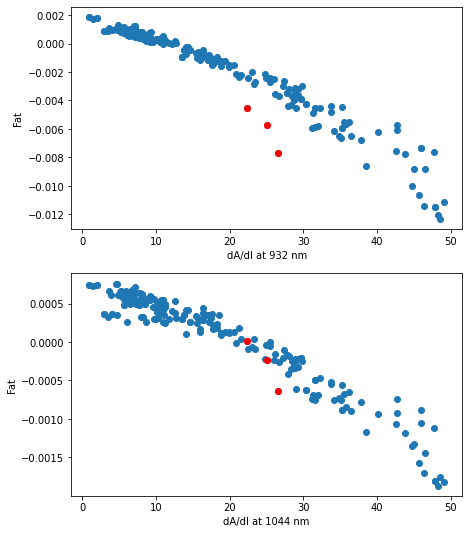

In [18]:
fig, ax = plt.subplots(2,1, figsize = (7,9))
ax[0].scatter(fat_array,ddab_array[:,41])
ax[1].scatter(fat_array,ddab_array[:,97])

ax[0].scatter(fat_array[out_inds],ddab_array[:,41][out_inds], c='r')
ax[1].scatter(fat_array[out_inds],ddab_array[:,97][out_inds], c='r')

ax[0].set_xlabel(f'dA/dl at {850+41*2} nm')
ax[1].set_xlabel(f'dA/dl at {850+97*2} nm')
ax[0].set_ylabel('Fat')
ax[1].set_ylabel('Fat')

## Composants de Fourier des dérivées d'ordre 1 et 2 ?

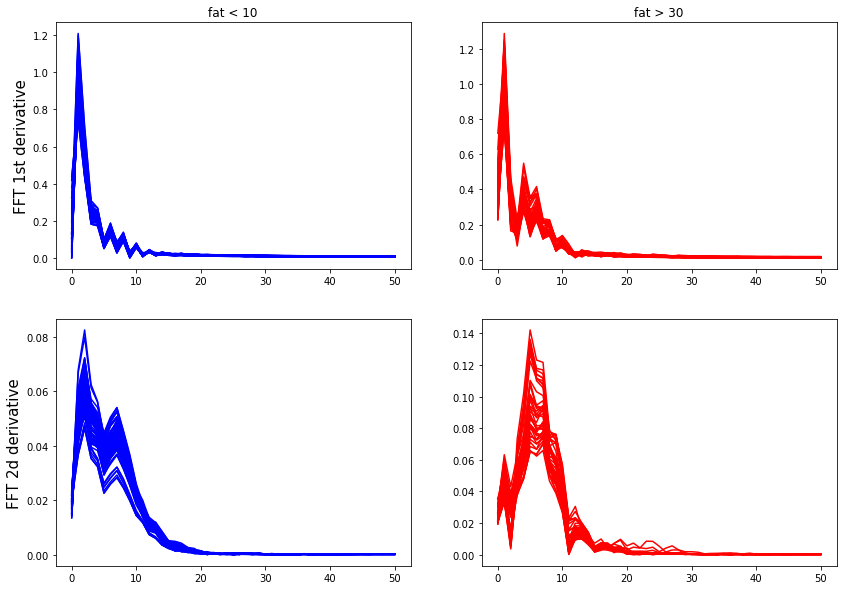

In [19]:
fft1_array = np.abs(np.fft.rfft(dab_array,axis=-1))
fft1_array = np.abs(np.fft.rfft(dab_array,axis=-1))
fft1_highF = fft1_array[fat_array>=30]
fft1_lowF = fft1_array[fat_array<10]

fft2_array = np.abs(np.fft.rfft(ddab_array,axis=-1))
fft2_array = np.abs(np.fft.rfft(ddab_array,axis=-1))
fft2_highF = fft2_array[fat_array>=30]
fft2_lowF = fft2_array[fat_array<10]

fig, ax = plt.subplots(2,2, figsize=(14,10))

for s in fft1_lowF:
    ax[0,0].plot(s, c='b')
    ax[0,0].set_title('fat < 10')
    ax[0,0].set_ylabel('FFT 1st derivative', size=15)
    
for s in fft1_highF:
    ax[0,1].plot(s, c='r')
    ax[0,1].set_title('fat > 30')
    
for s in fft2_lowF:
    ax[1,0].plot(s, c='b')
    ax[1,0].set_ylabel('FFT 2d derivative', size=15)
    
for s in fft2_highF:
    ax[1,1].plot(s, c='r')

Il faudra tenter de prendre en compte au moins les 15-20 premiers composants de Fourier.

## Principal components VS fat

In [20]:
from sklearn.decomposition import PCA

[Text(1, 0.0, 'low'), Text(1, 1.0, 'high')]

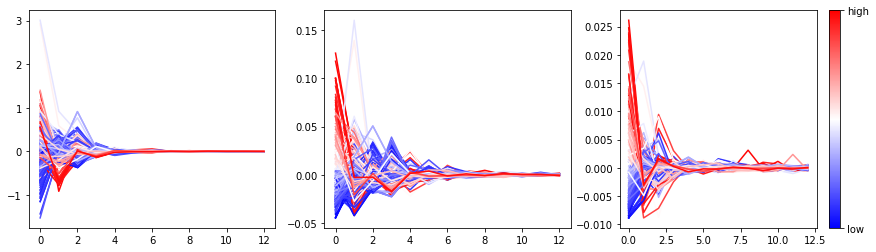

In [21]:
pca = PCA(n_components=13)
pc_array2 = pca.fit_transform(ab_tare_array)
# pc_array = pc_array/pc_array.std(axis = 0).reshape(1,-1)

dpca = PCA(n_components=13)
dpc_array = dpca.fit_transform(dab_array)
# dpc_array = dpc_array/dpc_array.std(axis = 0).reshape(1,-1)

ddpca = PCA(n_components=13)
ddpc_array = ddpca.fit_transform(ddab_array)
# ddpc_array = ddpc_array/ddpc_array.std(axis = 0).reshape(1,-1)

fig, ax = plt.subplots(1,3,figsize=(15,4))
ax[0].set_prop_cycle('color', list(cm_fat))
ax[1].set_prop_cycle('color', list(cm_fat))
ax[2].set_prop_cycle('color', list(cm_fat))

for i in range(n_samples):
    ax[0].plot(range(len(pc_array2[i])),pc_array2[i])
    ax[1].plot(range(len(dpc_array[i])),dpc_array[i])
    ax[2].plot(range(len(ddpc_array[i])),ddpc_array[i])

sm = plt.cm.ScalarMappable(cmap='bwr')
sm.set_array([])
  
cbar = fig.colorbar(sm, ticks=np.linspace(0, 1, 2))
cbar.ax.set_yticklabels(['low', 'high'])

% gras versus 1ère composante principale

Text(0.5, 1.0, '1st PC of ddA/ddl  versus  Fat')

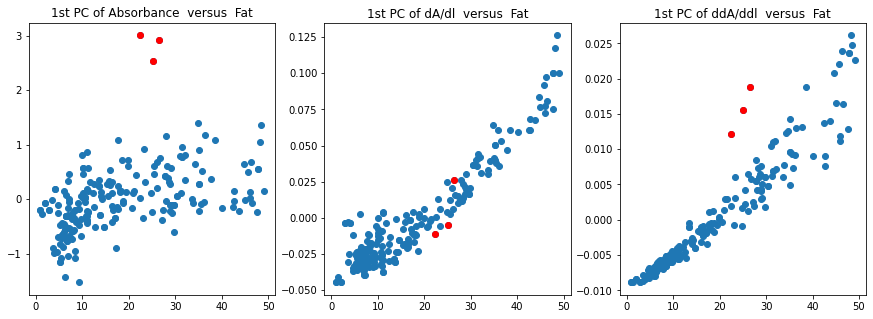

In [22]:
fig, ax = plt.subplots(1,3, figsize = (15,5))

ax[0].scatter(fat_array,pc_array2[:,0])
ax[1].scatter(fat_array,dpc_array[:,0])
ax[2].scatter(fat_array,ddpc_array[:,0])

ax[0].scatter(fat_array[out_inds],pc_array2[:,0][out_inds], c='r')
ax[1].scatter(fat_array[out_inds],dpc_array[:,0][out_inds], c='r')
ax[2].scatter(fat_array[out_inds],ddpc_array[:,0][out_inds], c='r')

ax[0].set_title('1st PC of Absorbance  versus  Fat')
ax[1].set_title('1st PC of dA/dl  versus  Fat')
ax[2].set_title('1st PC of ddA/ddl  versus  Fat')

On représente les échantillons dans l'espace des deux premières PC.
Les trois outliers sont confirmés

Text(0, 0.5, 'PC 2')

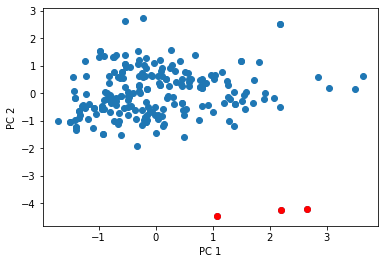

In [16]:
plt.scatter(pc_array[:,0],pc_array[:,1])
plt.scatter(pc_array[:,0][out_inds],pc_array[:,1][out_inds], c='r')
plt.xlabel('PC 1')
plt.ylabel('PC 2')

On pourra essayer le **kernel PCA**, qui effectue une projection non linéaire.

[Text(1, 0.0, 'low'), Text(1, 1.0, 'high')]

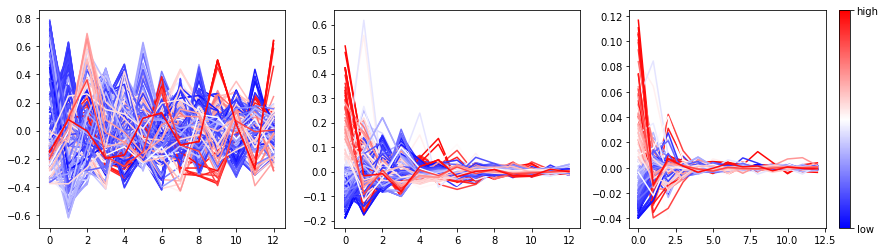

In [22]:
from sklearn.decomposition import KernelPCA

kpca = KernelPCA(
    n_components=13, kernel="rbf", gamma=10, fit_inverse_transform=True, alpha=0.1
)
kpc_array = kpca.fit_transform(ab_tare_array)
# pc_array = pc_array/pc_array.std(axis = 0).reshape(1,-1)

kdpca = KernelPCA(
    n_components=13, kernel="rbf", gamma=10, fit_inverse_transform=True, alpha=0.1
)
kdpc_array = kdpca.fit_transform(dab_array)
# dpc_array = dpc_array/dpc_array.std(axis = 0).reshape(1,-1)

kddpca = KernelPCA(
    n_components=13, kernel="rbf", gamma=10, fit_inverse_transform=True, alpha=0.1
)
kddpc_array = kddpca.fit_transform(ddab_array)
# ddpc_array = ddpc_array/ddpc_array.std(axis = 0).reshape(1,-1)

fig, ax = plt.subplots(1,3,figsize=(15,4))
ax[0].set_prop_cycle('color', list(cm_fat))
ax[1].set_prop_cycle('color', list(cm_fat))
ax[2].set_prop_cycle('color', list(cm_fat))

for i in range(n_samples):
    ax[0].plot(range(len(kpc_array[i])),kpc_array[i])
    ax[1].plot(range(len(kdpc_array[i])),kdpc_array[i])
    ax[2].plot(range(len(kddpc_array[i])),kddpc_array[i])

sm = plt.cm.ScalarMappable(cmap='bwr')
sm.set_array([])
  
cbar = fig.colorbar(sm, ticks=np.linspace(0, 1, 2))
cbar.ax.set_yticklabels(['low', 'high'])

Text(0.5, 1.0, '1st PC of ddA/ddl  versus  Fat')

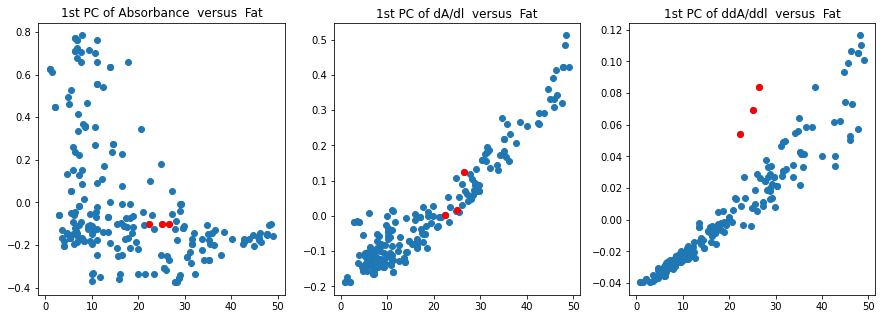

In [25]:
fig, ax = plt.subplots(1,3, figsize = (15,5))

ax[0].scatter(fat_array,kpc_array[:,0])
ax[1].scatter(fat_array,kdpc_array[:,0])
ax[2].scatter(fat_array,kddpc_array[:,0])

ax[0].scatter(fat_array[out_inds],kpc_array[:,0][out_inds], c='r')
ax[1].scatter(fat_array[out_inds],kdpc_array[:,0][out_inds], c='r')
ax[2].scatter(fat_array[out_inds],kddpc_array[:,0][out_inds], c='r')

ax[0].set_title('1st PC of Absorbance  versus  Fat')
ax[1].set_title('1st PC of dA/dl  versus  Fat')
ax[2].set_title('1st PC of ddA/ddl  versus  Fat')

# Simple model: linear regression with L2 regulation

In [27]:
from sklearn import linear_model

def RMSE(y1, y2):
    return np.sqrt(np.mean((y1-y2)**2))

## Régression linéaire à partir des indices visuels ci-dessus

(valeurs particulières des dérivées, premières composantes principales des dérivées)

In [27]:
X_ = np.concatenate((dab_array[:,31].reshape(-1,1),dab_array[:,42].reshape(-1,1),\
ddab_array[:,41].reshape(-1,1), ddab_array[:,97].reshape(-1,1),\
dpc_array[:,0].reshape(-1,1), ddpc_array[:,0].reshape(-1,1)), axis = -1)

Y_ = fat_array

#enlever les 3 outliers :
X_ = X_[out_inds==False]
Y_ = Y_[out_inds==False]

In [28]:
split_ind = 172

X_train, Y_train = X_[:split_ind], Y_[:split_ind]
X_test, Y_test = X_[split_ind:], Y_[split_ind:]

minimum test rmse with ridge regression = 2.81
test rmse with linear regression = 2.81


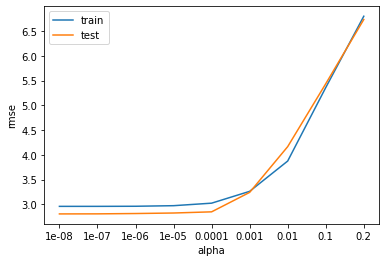

In [29]:
alpha_list = [1e-8,1e-7,1e-6,1e-5, 1e-4,1e-3,1e-2,0.1,0.2]
list_score_test = []
list_score_train = []
for a in alpha_list:
    model = linear_model.Ridge(alpha=a)
    model.fit(X_train, Y_train)
    y_pred_test = model.predict(X_test)
    y_pred_train = model.predict(X_train)
    list_score_test.append(RMSE(Y_test, y_pred_test))
    list_score_train.append(RMSE(Y_train, y_pred_train))

plt.plot(list_score_train, label='train')
plt.plot(list_score_test, label='test')
plt.legend()
plt.xticks(range(len(alpha_list)),alpha_list)
plt.xlabel('alpha')
plt.ylabel('rmse')

print(f'minimum test rmse with ridge regression = {np.round(np.min(list_score_test),2)}')

model = linear_model.LinearRegression()
model.fit(X_train, Y_train)
y_pred = model.predict(X_test)

print(f'test rmse with linear regression = {np.round(RMSE(Y_test, y_pred), 2)}')

## Régression à partir du spectre d'absorbance et de ses composantes principales

### Régression linéaire à partir du spectre d'absorbance

In [30]:
split_ind = 172

# Si on ne prend que les valeurs d'absorbance autour de la première bosse,
# le rmse avec alpha = 0 diminue
# X_train, Y_train = ab_tare_array[:split_ind,25:50], fat_array[:split_ind]
# X_test, Y_test = ab_tare_array[split_ind:,25:50], fat_array[split_ind:]

# On peut obtenir un meilleur rmse (à alpha!=0) avec toutes les valeurs
# X_train, Y_train = ab_tare_array[:split_ind,:], fat_array[:split_ind]
# X_test, Y_test = ab_tare_array[split_ind:,:], fat_array[split_ind:]

# On enlève les 3 outliers
X_train, Y_train = ab_tare_array[:split_ind][out_inds[:split_ind]==0], fat_array[:split_ind][out_inds[:split_ind]==0]
X_test, Y_test = ab_tare_array[split_ind:], fat_array[split_ind:]

minimum test rmse with ridge regression = 1.98
test rmse with linear regression = 4.22


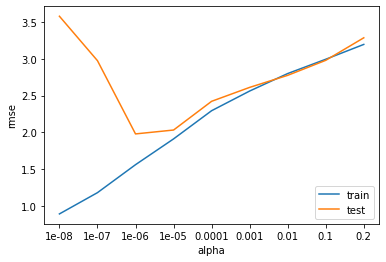

In [31]:
alpha_list = [1e-8,1e-7,1e-6,1e-5, 1e-4,1e-3,1e-2,0.1,0.2]
list_score_test = []
list_score_train = []
for a in alpha_list:
    model = linear_model.Ridge(alpha=a)
    model.fit(X_train, Y_train)
    y_pred_test = model.predict(X_test)
    y_pred_train = model.predict(X_train)
    list_score_test.append(RMSE(Y_test, y_pred_test))
    list_score_train.append(RMSE(Y_train, y_pred_train))

plt.plot(list_score_train, label='train')
plt.plot(list_score_test, label='test')
plt.legend()
plt.xticks(range(len(alpha_list)),alpha_list)
plt.xlabel('alpha')
plt.ylabel('rmse')

print(f'minimum test rmse with ridge regression = {np.round(np.min(list_score_test),2)}')

model = linear_model.LinearRegression()
model.fit(X_train, Y_train)
y_pred = model.predict(X_test)

print(f'test rmse with linear regression = {np.round(RMSE(Y_test, y_pred), 2)}')

### Régression linéaire sur les composants principaux

In [32]:
# X_train, Y_train = pc_array[:split_ind], fat_array[:split_ind]
# X_test, Y_test = pc_array[split_ind:], fat_array[split_ind:]

# sans les outliers,  on améliore le rmse de 0.1:
X_train, Y_train = pc_array[:split_ind][no_out_inds[:split_ind]], fat_array[:split_ind][no_out_inds[:split_ind]]
X_test, Y_test = pc_array[split_ind:,:], fat_array[split_ind:]

minimum test rmse with ridge regression = 2.12
test rmse with linear regression = 2.12


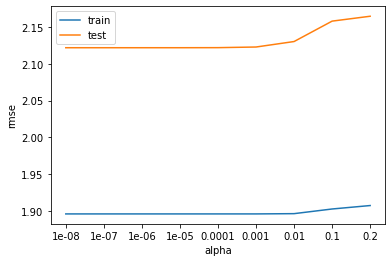

In [33]:
alpha_list = [1e-8,1e-7,1e-6,1e-5, 1e-4,1e-3,1e-2,0.1,0.2]
list_score_test = []
list_score_train = []
for a in alpha_list:
    model = linear_model.Ridge(alpha=a)
    model.fit(X_train, Y_train)
    y_pred_test = model.predict(X_test)
    y_pred_train = model.predict(X_train)
    list_score_test.append(RMSE(Y_test, y_pred_test))
    list_score_train.append(RMSE(Y_train, y_pred_train))

plt.plot(list_score_train, label='train')
plt.plot(list_score_test, label='test')
plt.legend()
plt.xticks(range(len(alpha_list)),alpha_list)
plt.xlabel('alpha')
plt.ylabel('rmse')

print(f'minimum test rmse with ridge regression = {np.round(np.min(list_score_test),2)}')

model = linear_model.LinearRegression()
model.fit(X_train, Y_train)
y_pred = model.predict(X_test)

print(f'test rmse with linear regression = {np.round(RMSE(Y_test, y_pred), 2)}')

test rmse on linear regression as a function of last principal component used (numbered between 0 and 21)

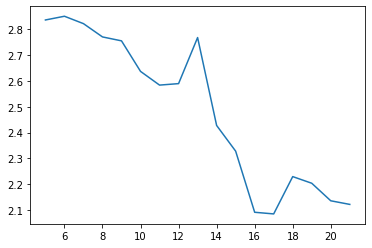

In [34]:
list_score = []
for n_pc in np.arange(5,22)+1:
#     X_train, Y_train = pc_array[:split_ind,:n_pc], fat_array[:split_ind]
#     X_test, Y_test = pc_array[split_ind:,:n_pc], fat_array[split_ind:]
    X_train, Y_train = pc_array[:split_ind,:n_pc][no_out_inds[:split_ind]], fat_array[:split_ind][no_out_inds[:split_ind]]
    X_test, Y_test = pc_array[split_ind:,:n_pc], fat_array[split_ind:]

    model = linear_model.LinearRegression()
    model.fit(X_train, Y_train)
    y_pred = model.predict(X_test)
    list_score.append(RMSE(Y_test, y_pred))
    
plt.plot(np.arange(5,22), list_score)

On retrouve rmse ~2,8 pour une régression linéaire à partir de 10 PCs.

En sélectionnant les PCs, on retombe se rapproche sur le résultat obtenu avec RidgeRegression à partir du spectre complet.

### Régression linéaire à partir des PCs et kernel-PCs des dérivées

In [35]:
# kpc donne des très mauvais résultats (rmse=10), pire que pc
# X_train, Y_train = kpc_array[:split_ind], fat_array[:split_ind]
# X_test, Y_test = kpc_array[split_ind:,:], fat_array[split_ind:]


# Mais kdpc donne de meilleurs résultats (rmse=1.14) que dpc (2.54)
# kddpc donne de légèrement moins bon résultats que kdpc
X_train, Y_train = kdpc_array[:split_ind], fat_array[:split_ind]
X_test, Y_test = kdpc_array[split_ind:,:], fat_array[split_ind:]

# X_train, Y_train = dpc_array[:split_ind], fat_array[:split_ind]
# X_test, Y_test = dpc_array[split_ind:,:], fat_array[split_ind:]

minimum test rmse with ridge regression = 1.14
test rmse with linear regression = 1.18


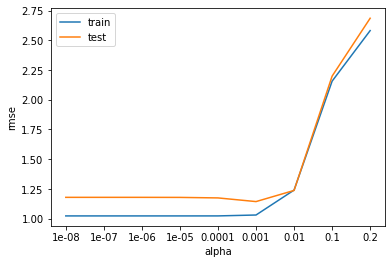

In [36]:
alpha_list = [1e-8,1e-7,1e-6,1e-5, 1e-4,1e-3,1e-2,0.1,0.2]
list_score_test = []
list_score_train = []
for a in alpha_list:
    model = linear_model.Ridge(alpha=a)
    model.fit(X_train, Y_train)
    y_pred_test = model.predict(X_test)
    y_pred_train = model.predict(X_train)
    list_score_test.append(RMSE(Y_test, y_pred_test))
    list_score_train.append(RMSE(Y_train, y_pred_train))

plt.plot(list_score_train, label='train')
plt.plot(list_score_test, label='test')
plt.legend()
plt.xticks(range(len(alpha_list)),alpha_list)
plt.xlabel('alpha')
plt.ylabel('rmse')

print(f'minimum test rmse with ridge regression = {np.round(np.min(list_score_test),2)}')

model = linear_model.LinearRegression()
model.fit(X_train, Y_train)
y_pred = model.predict(X_test)

print(f'test rmse with linear regression = {np.round(RMSE(Y_test, y_pred), 2)}')

## Utilisation FFT de la dérivée seconde dans la régression linéaire

tests rapides de différentes combinaisons

In [37]:
split_ind = 172

#les résultats affichés sont les score rmse min et la std des scores (voir plus bas)

# rmse = 1.4   std = 0.03
# X_train, Y_train = fft1_array[:split_ind,:15], fat_array[:split_ind]
# X_test, Y_test = fft1_array[split_ind:,:15], fat_array[split_ind:]

# rmse = 1.6   std = 0.03
# X_train, Y_train = fft2_array[:split_ind,:15], fat_array[:split_ind]
# X_test, Y_test = fft2_array[split_ind:,:15], fat_array[split_ind:]

# rmse = 1.22 std = 0.04
# X_train, Y_train = np.concatenate((fft1_array[:split_ind,:15],\
#                                   fft2_array[:split_ind,:15]), axis=-1), fat_array[:split_ind]
# X_test, Y_test = np.concatenate((fft1_array[split_ind:,:15],\
#                                 fft2_array[split_ind:,:15]), axis=-1), fat_array[split_ind:]

# rmse = 0.99   std = 0.09
# X_train, Y_train = np.concatenate((ab_tare_array[:split_ind], \
#                                    fft1_array[:split_ind,:15]), axis=-1), fat_array[:split_ind]
# X_test, Y_test = np.concatenate((ab_tare_array[split_ind:], \
#                                  fft1_array[split_ind:,:15]), axis=-1), fat_array[split_ind:]

# rmse = 0.81   std = 0.07
# X_train, Y_train = np.concatenate((kdpc_array[:split_ind], kddpc_array[:split_ind],\
#                                    fft1_array[:split_ind,:15]), axis=-1), fat_array[:split_ind]
# X_test, Y_test = np.concatenate((kdpc_array[split_ind:], kddpc_array[split_ind:],\
#                                  fft1_array[split_ind:,:15]), axis=-1), fat_array[split_ind:]

# rmse = 1.02   std = 0.03
# X_train, Y_train = np.concatenate((kddpc_array[:split_ind], kddpc_array[:split_ind],\
#                                    fft2_array[:split_ind,:15]), axis=-1), fat_array[:split_ind]
# X_test, Y_test = np.concatenate((kddpc_array[split_ind:], kddpc_array[split_ind:],\
#                                  fft2_array[split_ind:,:15]), axis=-1), fat_array[split_ind:]

# rmse = 0.63 std = 0.04
# X_train, Y_train = np.concatenate((kdpc_array[:split_ind], kddpc_array[:split_ind],\
#                                    fft1_array[:split_ind,:15],\
#                                   fft2_array[:split_ind,:15]), axis=-1), fat_array[:split_ind]
# X_test, Y_test = np.concatenate((kdpc_array[split_ind:], kddpc_array[split_ind:],\
#                                  fft1_array[split_ind:,:15],\
#                                 fft2_array[split_ind:,:15]), axis=-1), fat_array[split_ind:]

# rmse = 0.63 std = 0.02 (mais meilleur résultat à alpha = 0)
# X_train, Y_train = np.concatenate((kdpc_array[:split_ind], \
#                                    fft1_array[:split_ind,:15],\
#                                   fft2_array[:split_ind,:15]), axis=-1), fat_array[:split_ind]
# X_test, Y_test = np.concatenate((kdpc_array[split_ind:], \
#                                  fft1_array[split_ind:,:15],\
#                                 fft2_array[split_ind:,:15]), axis=-1), fat_array[split_ind:]

# rmse = 0.58 std = 0.05
X_train, Y_train = np.concatenate((pc_array2[:split_ind,:], \
                                   kdpc_array[:split_ind], \
                                   fft1_array[:split_ind,:15],\
                                  fft2_array[:split_ind,:15]), axis=-1), fat_array[:split_ind]
X_test, Y_test = np.concatenate((pc_array2[split_ind:,:], \
                                 kdpc_array[split_ind:], \
                                 fft1_array[split_ind:,:15],\
                                fft2_array[split_ind:,:15]), axis=-1), fat_array[split_ind:]

minimum test rmse with ridge regression = 0.58
test rmse with linear regression = 0.61
best alpha = 3.0000000000000004e-08


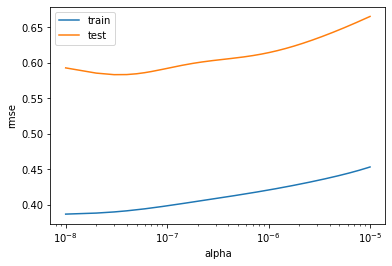

In [38]:
alpha_list = np.linspace(1e-8,1e-5,1000)
list_score_test = []
list_score_train = []
for a in alpha_list:
    model = linear_model.Ridge(alpha=a)
    model.fit(X_train, Y_train)
    y_pred_test = model.predict(X_test)
    y_pred_train = model.predict(X_train)
    list_score_test.append(RMSE(Y_test, y_pred_test))
    list_score_train.append(RMSE(Y_train, y_pred_train))
    
plt.plot(alpha_list, list_score_train, label='train')
plt.plot(alpha_list, list_score_test, label='test')
plt.legend()
plt.xscale('log')
plt.xlabel('alpha')
plt.ylabel('rmse')

print(f'minimum test rmse with ridge regression = {np.round(np.min(list_score_test),2)}')

model = linear_model.LinearRegression()
model.fit(X_train, Y_train)
y_pred = model.predict(X_test)

print(f'test rmse with linear regression = {np.round(RMSE(Y_test, y_pred), 2)}')

print(f'best alpha = {alpha_list[np.argmin(list_score_test)]}')

Test robustesse avec échantillons en moins dans le dataset 

In [39]:
from sklearn.model_selection import ShuffleSplit

std score = 0.05037984800367478


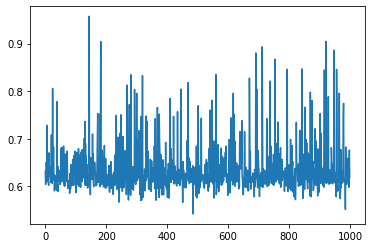

In [40]:
n_splits = 1000
# à chaque set d'entraînement, 5 échantillons sont enlevés au hasard.
rs = ShuffleSplit(n_splits=n_splits, test_size=5)

rs.get_n_splits(X_train)

train_splits = [s[0] for s in rs.split(X_train)]

score = []
for i in range(n_splits):
    
    X_train_cut, Y_train_cut = X_train[train_splits[i]], Y_train[train_splits[i]]

#     model = linear_model.Ridge(alpha=best_alpha)
    model = linear_model.LinearRegression()
    model.fit(X_train_cut, Y_train_cut)
    y_pred = model.predict(X_test)

    score.append(RMSE(Y_test, y_pred))
#     print(f'split {i} - test rmse with linear regression = {np.round(RMSE(Y_test, y_pred), 2)}')

print(f'std score = {np.std(score)}')
plt.plot(score)

## conclusion sur la régression linéaire :

Les résultats obtenus avec les fft des dérivées + les Kernel-PC des dérivées (avec éventuellement les PC de l'absorbance) sont les plus prometteurs.

# Quelques modèles un peu plus sophistiqués

Avec les bons inputs (kernel PC et FFT), le processus Gaussien et le Kernel Ridge donnent  
- des scores rmse autour de 0.5
- des modèles plus robustes

Les arbres semblent peu adaptés (probablement dû à trop peu de données et un déséquilibre entre les échantillons gras et les échantillons maigres).

## Gaussian process

In [17]:
from sklearn.model_selection import GridSearchCV
from sklearn.gaussian_process import GaussianProcessRegressor

In [24]:
split_ind = 172

In [25]:
# Ce qui fonctionne le mieux : kdpc+fft  
# (dpc donne de moins bons résultat que kdpc)

# rmse = 0.51 std = 0.02
X_train, Y_train = np.concatenate((kdpc_array[:split_ind], \
                                   fft2_array[:split_ind,:15]), axis=-1), fat_array[:split_ind]
X_test, Y_test = np.concatenate((kdpc_array[split_ind:], \
                                 fft2_array[split_ind:,:15]), axis=-1), fat_array[split_ind:]


# rmse = 0.49 std = 0.03 
# X_train, Y_train = np.concatenate((kdpc_array[:split_ind], \
#                                    fft1_array[:split_ind,:15],\
#                                   fft2_array[:split_ind,:15]), axis=-1), fat_array[:split_ind]
# X_test, Y_test = np.concatenate((kdpc_array[split_ind:], \
#                                  fft1_array[split_ind:,:15],\
#                                 fft2_array[split_ind:,:15]), axis=-1), fat_array[split_ind:]


# Avec plus d'inputs,  le GP ne fait pas mieux:
# rmse = 0.55  std = 0.05
# X_train, Y_train = np.concatenate((pc_array2[:split_ind,:], \
#                                    kdpc_array[:split_ind], \
#                                    fft1_array[:split_ind,:15],\
#                                   fft2_array[:split_ind,:15]), axis=-1), fat_array[:split_ind]
# X_test, Y_test = np.concatenate((pc_array2[split_ind:,:], \
#                                  kdpc_array[split_ind:], \
#                                  fft1_array[split_ind:,:15],\
#                                 fft2_array[split_ind:,:15]), axis=-1), fat_array[split_ind:]

Grid search

In [28]:
parameters_GS = {'alpha':np.linspace(1e-7,1e-5,20)}
GS = GridSearchCV(GaussianProcessRegressor(), parameters_GS, scoring = 'neg_root_mean_squared_error', cv = 100)
# Notons que choisir un nombre de splits plus grand pour la cross-validation donne un meilleur score
# Si on veut le meilleur score en CV, il faut bien sûr avoir le nombre de splits maximum !

GS.fit(X_train, Y_train)

print(f'best params = {GS.best_params_}')
print('mean CV score = {}'.format(-GS.cv_results_['mean_test_score'].mean()))

model = GaussianProcessRegressor(**GS.best_params_)

model.fit(X_train, Y_train)

y_pred_test = model.predict(X_test)
y_pred_train = model.predict(X_train)

print(f'test rmse = {np.round(RMSE(y_pred_test, Y_test),2)}')
print(f'train rmse = {np.round(RMSE(y_pred_train, Y_train),2)}')

best params = {'alpha': 1e-05}
mean CV score = 0.4882716177898718
test rmse = 0.51
train rmse = 0.29


In [30]:
y_pred_test = model.predict(X_test, return_std = True)

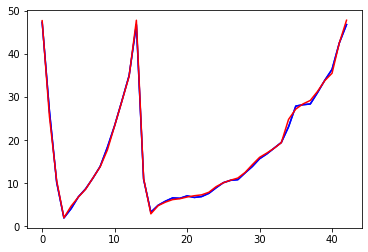

In [37]:
plt.plot(y_pred_test[0]+y_pred_test[1], c='b')
plt.plot(y_pred_test[0]-y_pred_test[1], c='b')
plt.plot(Y_test, c='r')

Check meilleur rmse sur dataset de test

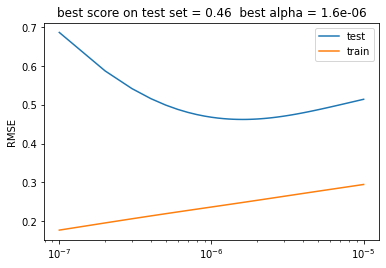

In [44]:
scores_test = []
scores_train = []
alphas = np.linspace(1e-7,1e-5,100)

for a in alphas:
    model = GaussianProcessRegressor(alpha = a)
    model.fit(X_train, Y_train)

    y_pred_test = model.predict(X_test)
    y_pred_train = model.predict(X_train)

    scores_test.append(RMSE(y_pred_test, Y_test))
    scores_train.append(RMSE(y_pred_train, Y_train))

plt.plot(alphas, scores_test, label='test')
plt.plot(alphas, scores_train, label='train')
best_alpha = alphas[np.argmin(scores_test)]
plt.title(f'best score on test set = {np.round(min(scores_test),2)}  best alpha = {best_alpha}')
plt.xscale('log')
plt.ylabel('RMSE')
plt.legend()

Check robustesse

std score = 0.022768350357229697


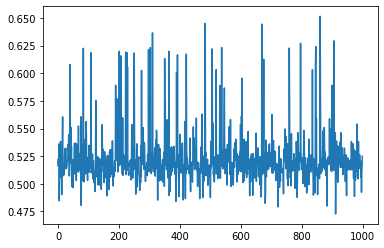

In [45]:
n_splits = 1000
# training sets with 5 sample removed each time
rs = ShuffleSplit(n_splits=n_splits, test_size=5)

rs.get_n_splits(X_train)

train_splits = [s[0] for s in rs.split(X_train)]

score = []
for i in range(n_splits):
    
    X_train_cut, Y_train_cut = X_train[train_splits[i]], Y_train[train_splits[i]]

    model = GaussianProcessRegressor(**GS.best_params_)
#     model = GaussianProcessRegressor(alpha = best_alpha)
    model.fit(X_train_cut, Y_train_cut)
    y_pred = model.predict(X_test)

    score.append(RMSE(Y_test, y_pred))
#     print(f'split {i} - test rmse with linear regression = {np.round(RMSE(Y_test, y_pred), 2)}')

print(f'std score = {np.std(score)}')
plt.plot(score)

## Kernel Ridge

In [46]:
from sklearn.kernel_ridge import KernelRidge

In [47]:
# Ce qui fonctionne le mieux : les kdpc+fft  
# (dpc donne de moins bons résultats que kdpc)

#rmse = 0.52  std = 0.3
# X_train, Y_train = np.concatenate((kdpc_array[:split_ind], \
#                                    fft1_array[:split_ind,:15]), axis=-1), fat_array[:split_ind]
# X_test, Y_test = np.concatenate((kdpc_array[split_ind:], \
#                                  fft1_array[split_ind:,:15]), axis=-1), fat_array[split_ind:]

#rmse = 0.48  std = 0.4
# X_train, Y_train = np.concatenate((ab_tare_array[:split_ind], \
#                                    kdpc_array[:split_ind], \
#                                    fft1_array[:split_ind,:15]), axis=-1), fat_array[:split_ind]
# X_test, Y_test = np.concatenate((ab_tare_array[split_ind:],\
#                                  kdpc_array[split_ind:], \
#                                  fft1_array[split_ind:,:15]), axis=-1), fat_array[split_ind:]

#rmse = 0.49  std = 0.2
X_train, Y_train = np.concatenate((kdpc_array[:split_ind], \
                                   fft1_array[:split_ind,:15],\
                                  fft2_array[:split_ind,:15]), axis=-1), fat_array[:split_ind]
X_test, Y_test = np.concatenate((kdpc_array[split_ind:], \
                                 fft1_array[split_ind:,:15],\
                                fft2_array[split_ind:,:15]), axis=-1), fat_array[split_ind:]

#rmse = 0.49  std = 0.3
# X_train, Y_train = np.concatenate((pc_array2[:split_ind,:], \
#                                    kdpc_array[:split_ind], \
#                                    fft1_array[:split_ind,:15],\
#                                   fft2_array[:split_ind,:15]), axis=-1), fat_array[:split_ind]
# X_test, Y_test = np.concatenate((pc_array2[split_ind:,:], \
#                                  kdpc_array[split_ind:], \
#                                  fft1_array[split_ind:,:15],\
#                                 fft2_array[split_ind:,:15]), axis=-1), fat_array[split_ind:]

#rmse = 0.48  std = 0.3
# X_train, Y_train = np.concatenate((ab_tare_array[:split_ind,:], \
#                                    kdpc_array[:split_ind], \
#                                    fft1_array[:split_ind,:15],\
#                                   fft2_array[:split_ind,:15]), axis=-1), fat_array[:split_ind]
# X_test, Y_test = np.concatenate((ab_tare_array[split_ind:,:], \
#                                  kdpc_array[split_ind:], \
#                                  fft1_array[split_ind:,:15],\
#                                 fft2_array[split_ind:,:15]), axis=-1), fat_array[split_ind:]

In [48]:
parameters_GS = {'kernel':['linear','rbf', 'polynomial'],'alpha':np.linspace(1e-8,1e-6,20)}
GS = GridSearchCV(KernelRidge(), parameters_GS, scoring = 'neg_root_mean_squared_error', cv=100)
# Attention ! dataset petit -> la cross-validation est très sensible au nombres de splits.

GS.fit(X_train, Y_train)

print(f'best params = {GS.best_params_}')
print('mean CV score = {}'.format(-GS.cv_results_['mean_test_score'].mean()))

model = KernelRidge(**GS.best_params_)

model.fit(X_train, Y_train)

y_pred_test = model.predict(X_test)
y_pred_train = model.predict(X_train)

print(f'test rmse = {np.round(RMSE(y_pred_test, Y_test),2)}')

print(f'train rmse = {np.round(RMSE(y_pred_train, Y_train),2)}')

best params = {'alpha': 1.6631578947368422e-07, 'kernel': 'rbf'}
mean CV score = 0.5393704734417971
test rmse = 0.49
train rmse = 0.27


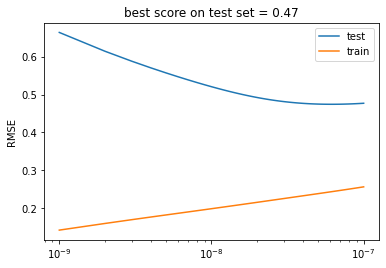

In [49]:
scores_test = []
scores_train = []
alphas = np.linspace(1e-9,1e-7,100)

for a in alphas:
    model = KernelRidge(alpha = a, kernel = 'rbf')
    model.fit(X_train, Y_train)

    y_pred_test = model.predict(X_test)
    y_pred_train = model.predict(X_train)

    scores_test.append(RMSE(y_pred_test, Y_test))
    scores_train.append(RMSE(y_pred_train, Y_train))

plt.plot(alphas, scores_test, label='test')
plt.plot(alphas, scores_train, label='train')
plt.title(f'best score on test set = {np.round(min(scores_test),2)}')

plt.xscale('log')
plt.ylabel('RMSE')
plt.legend()

Test robustesse du Kernel Ridge % retirer des échantillons

std score = 0.022258264474782224


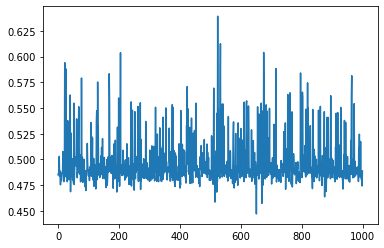

In [50]:
n_splits = 1000
# training sets with 5 sample removed each time
rs = ShuffleSplit(n_splits=n_splits, test_size=5)
# rs = ShuffleSplit(n_splits=n_splits)


rs.get_n_splits(X_train)

train_splits = [s[0] for s in rs.split(X_train)]

score = []
for i in range(n_splits):
    
    X_train_cut, Y_train_cut = X_train[train_splits[i]], Y_train[train_splits[i]]

    model = KernelRidge(**GS.best_params_)
    model.fit(X_train_cut, Y_train_cut)
    y_pred = model.predict(X_test)

    score.append(RMSE(Y_test, y_pred))
#     print(f'split {i} - test rmse with linear regression = {np.round(RMSE(Y_test, y_pred), 2)}')

print(f'std score = {np.std(score)}')
plt.plot(score)

## XGBoost

In [51]:
!pip show xgboost

Name: xgboost
Version: 0.90
Summary: XGBoost Python Package
Home-page: https://github.com/dmlc/xgboost
Author: None
Author-email: None
License: Apache-2.0
Location: /usr/local/lib/python3.8/dist-packages
Requires: numpy, scipy
Required-by: 


In [52]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from xgboost import XGBRegressor

In [53]:
# X_train, Y_train = np.concatenate((kdpc_array[:split_ind], \
#                                    fft1_array[:split_ind,:15],\
#                                   fft2_array[:split_ind,:15]), axis=-1), fat_array[:split_ind]
# X_test, Y_test = np.concatenate((kdpc_array[split_ind:], \
#                                  fft1_array[split_ind:,:15],\
#                                 fft2_array[split_ind:,:15]), axis=-1), fat_array[split_ind:]

X_train, Y_train = fft2_array[:split_ind,:15], fat_array[:split_ind]
X_test, Y_test = fft2_array[split_ind:,:15], fat_array[split_ind:]

In [54]:
parameters_GS = {'max_depth' : range(1,4), 'max_leaves':range(1,4), 'reg_lambda':np.linspace(1e-3,1e-2,10)}
GS = GridSearchCV(XGBRegressor(verbosity=0), parameters_GS, scoring = 'neg_root_mean_squared_error', cv=10)
# Attention ! dataset petit -> la cross-validation est très sensible au nombres de splits.

GS.fit(X_train, Y_train)

print(f'best params = {GS.best_params_}')
print('mean CV score = {}'.format(-GS.cv_results_['mean_test_score'].mean()))

model = XGBRegressor(**GS.best_params_)

model.fit(X_train, Y_train)

y_pred_test = model.predict(X_test)
y_pred_train = model.predict(X_train)

print(f'test rmse = {np.round(RMSE(y_pred_test, Y_test),2)}')

print(f'train rmse = {np.round(RMSE(y_pred_train, Y_train),2)}')

best params = {'max_depth': 3, 'max_leaves': 1, 'reg_lambda': 0.007}
mean CV score = 1.7125981070626637
[00:26:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
test rmse = 1.22
train rmse = 0.24


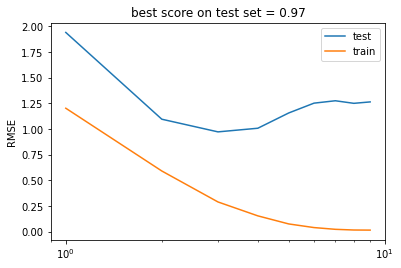

In [55]:
scores_test = []
scores_train = []
depths = range(1,10)

for d in depths:
    model = XGBRegressor(max_depth = d, max_leaves=5, verbosity=0)
    model.fit(X_train, Y_train)

    y_pred_test = model.predict(X_test)
    y_pred_train = model.predict(X_train)

    scores_test.append(RMSE(y_pred_test, Y_test))
    scores_train.append(RMSE(y_pred_train, Y_train))

plt.plot(depths, scores_test, label='test')
plt.plot(depths, scores_train, label='train')
plt.title(f'best score on test set = {np.round(min(scores_test),2)}')

plt.xscale('log')
plt.ylabel('RMSE')
plt.legend()

XGBoost overfit (si les arbres sont suffisamment profonds ou ramifiés), ou n'apprend pas assez (si on limite la taille des arbres)

# Utilisation de réseaux de neurones

À compléter

## Small NN

In [56]:
from sklearn.neural_network import MLPRegressor

In [57]:
# Ce qui fonctionne le mieux marche mieux avec les kdpc+fft  

# rmse = 0.6
X_train, Y_train = np.concatenate((kdpc_array[:split_ind], \
                                   fft2_array[:split_ind,:15]), axis=-1), fat_array[:split_ind]
X_test, Y_test = np.concatenate((kdpc_array[split_ind:], \
                                 fft2_array[split_ind:,:15]), axis=-1), fat_array[split_ind:]

# rmse = 0.64
# X_train, Y_train = np.concatenate((kdpc_array[:split_ind], \
#                                    fft1_array[:split_ind,:15],\
#                                   fft2_array[:split_ind,:15]), axis=-1), fat_array[:split_ind]
# X_test, Y_test = np.concatenate((kdpc_array[split_ind:], \
#                                  fft1_array[split_ind:,:15],\
#                                 fft2_array[split_ind:,:15]), axis=-1), fat_array[split_ind:]

In [58]:
parameters_GS = {'random_state':[0], 'alpha':[1e-3],'hidden_layer_sizes':[[50]*2,[100]*2], 'learning_rate_init':[5e-3], 'max_iter':[10000]}
GS = GridSearchCV(MLPRegressor(), parameters_GS, scoring = 'neg_root_mean_squared_error', cv=20)


GS.fit(X_train, Y_train)

print(f'best params = {GS.best_params_}')
print('mean CV score = {}'.format(-GS.cv_results_['mean_test_score'].mean()))

model = MLPRegressor(**GS.best_params_)

model.fit(X_train, Y_train)

y_pred_test = model.predict(X_test)
y_pred_train = model.predict(X_train)

print(f'test rmse = {np.round(RMSE(y_pred_test, Y_test),2)}')
print(f'train rmse = {np.round(RMSE(y_pred_train, Y_train),2)}')

best params = {'alpha': 0.001, 'hidden_layer_sizes': [100, 100], 'learning_rate_init': 0.005, 'max_iter': 10000, 'random_state': 0}
mean CV score = 0.7373353723003766
test rmse = 0.6
train rmse = 0.42


## Réseaux de neurones plus évolué

In [59]:
import torch
import torch.nn as nn
from torch.nn.utils import weight_norm

### Transformer

In [60]:
import math
class convolution(nn.Module):
    def __init__(self,input_channel, output_channel, kernel_size, dropout=0, batchnorm=True):
        super().__init__()
        self.conv = weight_norm(nn.Conv1d(input_channel, output_channel, kernel_size, padding=1))
        self.relu = nn.PReLU()
        self.drop = nn.Dropout(dropout)
        if batchnorm:
            self.BN = torch.nn.BatchNorm1d(output_channel)
            self.net = nn.Sequential(self.conv, self.BN, self.relu, self.drop)
        else:
            self.net = nn.Sequential(self.conv, self.relu, self.drop)
    def forward(self, X):
        return self.net(X)


class PositionalEncoding(nn.Module):

    def __init__(self, d_model, dropout=0.1, max_len=512):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.pe = pe

    def forward(self, x): # x has size [batch_size, len_seq, d_model]
        pe = torch.cat([self.pe[:x.size(1), :].unsqueeze(0) for n in range(x.size(0))])
        x = x + pe
        return self.dropout(x)


class CNN_transformer(nn.Module):
        def __init__(self, input_channel,\
                 conv_channel, kernel_size,\
                 hidden_linear,\
                 last_dim = 1,\
                 bidirectional = True,\
                 num_transformer = 1, hidden_feedforward = 128, nhead = 1,\
                 dropout = 0.1, dropout_cnn = 0., batch_norm = False):
            
            super().__init__()

            self.convolution = convolution(input_channel,conv_channel,kernel_size, dropout=dropout_cnn, batchnorm=batch_norm)

            self.pos_encoder = PositionalEncoding(conv_channel, dropout)
            encoder_layer = nn.TransformerEncoderLayer(conv_channel, nhead, dim_feedforward=hidden_feedforward, dropout=0.1, activation='relu')
            self.transformer = nn.TransformerEncoder(encoder_layer, num_transformer, norm=None)

            self.linear = nn.Linear(conv_channel, last_dim) 

        def forward(self, X):

            output = self.convolution(X.transpose(1,2)).transpose(1,2)

            output = self.pos_encoder(output)

            output = self.transformer(output)

            output = output.mean(dim=1)

            output = self.linear(output)
            return output

Juste un test :

In [61]:
model = CNN_transformer(input_channel=1,\
                 conv_channel=128, kernel_size=3,\
                 hidden_linear=128,\
                 last_dim = 1,\
                 num_transformer = 1, hidden_feedforward = 128, nhead = 1,\
                 dropout = 0.1, dropout_cnn = 0., batch_norm = True)

In [62]:
X_train, Y_train = ab_tare_array[:split_ind], fat_array[:split_ind]
X_test, Y_test = ab_tare_array[split_ind:], fat_array[split_ind:]

In [63]:
train_dataset = torch.utils.data.TensorDataset(torch.tensor(X_train).unsqueeze(-1).float(), torch.tensor(Y_train).float())
test_dataset = torch.utils.data.TensorDataset(torch.tensor(X_test).unsqueeze(-1).float(), torch.tensor(Y_test).float())

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=10)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=len(test_dataset))

In [64]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay = 1e-3)
loss_fn = nn.MSELoss()

loss_test = []
loss_train = []

epoch=10
for e in range(epoch):
    model.train()
    loss_list = []
    for X,Y in train_loader:
        Y_pred = model(X)
        loss = loss_fn(Y_pred, Y.unsqueeze(-1))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        loss_list.append(loss.item())
    loss_train.append(np.sqrt(np.mean(loss_list)))

    model.eval()
    loss_list = []
    for X,Y in test_loader:
        Y_pred = model(X).detach()
        loss = loss_fn(Y_pred, Y.unsqueeze(-1).detach())
        loss_list.append(loss.item())
    loss_test.append(np.sqrt(np.mean(loss_list)))

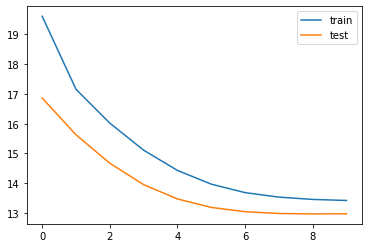

In [65]:
plt.plot(loss_train, label = 'train')
plt.plot(loss_test, label = 'test')
plt.legend()